In [1]:
import torch
import numpy as np
import wiredOR_dataset
from torch.utils.data import sampler
import time
from train_utils import *
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [3]:
window = 31
chunk_size = 100000
dset = wiredOR_dataset.WiredORDataset('/media/guest/data_9TB/jeffrey/data/2015-11-09-3/subset_0/dataset.h5', window, chunk_size)
num_electrode = dset.shape[0]
loader_train = torch.utils.data.DataLoader(torch.utils.data.Subset(dset, [1, 2, 3]))

In [4]:
out_ch_1 = 31
out_ch_2 = 20
out_ch_3 = 31

weight1 = random_weight((num_electrode - 1, 1, window, out_ch_1), device, dtype)
bias1 = zero_weight((num_electrode - 1, 1, out_ch_1), device, dtype)
weight2 = random_weight((num_electrode - 1, 1, out_ch_1, out_ch_2), device, dtype)
bias2 = zero_weight((num_electrode - 1, 1, out_ch_2), device, dtype)
weight3 = random_weight((num_electrode - 1, 1, out_ch_2, out_ch_3), device, dtype)
bias3 = zero_weight((num_electrode - 1, 1, out_ch_3), device, dtype)
params = [weight1, bias1, weight2, bias2, weight3, bias3]

In [5]:
lr = 5e-3
wd = 0 #0.9
optimizer = torch.optim.Adam(params, lr = lr, weight_decay = wd)
mb = 1000
epochs = 15
def train_decoder(loader, model_fn, params, optimizer):
    """
    """
    total_train_time = 0
    for epoch in range(epochs):
        for t, (x, y) in enumerate(loader):
            x = x.squeeze()
            y = y.squeeze()
            for _mb in range(chunk_size // mb):
                start_time = time.time()
                # Move the data to the proper device (GPU or CPU)
                x_tmp = x[1:, mb * _mb : mb * (_mb + 1)]
                x_tmp = x_tmp.to(device=device, dtype=dtype)
                y_tmp = y[1:, mb * _mb + window // 2 : mb * (_mb + 1) - window // 2]
                y_tmp = y_tmp.to(device=device, dtype=dtype)

                # Forward pass: compute scores and loss
                optimizer.zero_grad()
                scores = model_fn(x_tmp, params)
                loss = (scores - y_tmp).pow(2).sum()
                
                # Backward pass: PyTorch figures out which Tensors in the computational
                # graph has requires_grad=True and uses backpropagation to compute the
                # gradient of the loss with respect to these Tensors, and stores the
                # gradients in the .grad attribute of each Tensor.
                loss.backward()

                # Update parameters. We don't want to backpropagate through the
                # parameter updates, so we scope the updates under a torch.no_grad()
                # context manager to prevent a computational graph from being built.
                optimizer.step()
                train_time = time.time() - start_time
                total_train_time += train_time
        print("Total train time: %s, Loss: %s,  Epoch: %s" %(total_train_time, loss.item(), epoch))

In [6]:
train_decoder(loader_train, three_layer_decode, params, optimizer)

Total train time: 36.356121301651, Loss: 13850533.0,  Epoch: 0
Total train time: 72.86264109611511, Loss: 13613154.0,  Epoch: 1
Total train time: 109.41673564910889, Loss: 13568663.0,  Epoch: 2
Total train time: 146.0086088180542, Loss: 13536424.0,  Epoch: 3
Total train time: 182.60431933403015, Loss: 13506043.0,  Epoch: 4
Total train time: 219.19682669639587, Loss: 13481539.0,  Epoch: 5
Total train time: 255.78889799118042, Loss: 13487700.0,  Epoch: 6
Total train time: 292.38012647628784, Loss: 13464050.0,  Epoch: 7
Total train time: 328.9757511615753, Loss: 13454544.0,  Epoch: 8
Total train time: 365.5776307582855, Loss: 13444732.0,  Epoch: 9
Total train time: 402.1774535179138, Loss: 13439054.0,  Epoch: 10
Total train time: 438.7751405239105, Loss: 13433692.0,  Epoch: 11
Total train time: 475.3716561794281, Loss: 13426014.0,  Epoch: 12
Total train time: 511.9694149494171, Loss: 13422276.0,  Epoch: 13
Total train time: 548.5693390369415, Loss: 13413176.0,  Epoch: 14


# Visualize performance

In [36]:
batch_idx = 0
minibatch_idx = 6
minibatch_sz = 1000
raw_output = dset[batch_idx][0][1:, minibatch_idx * minibatch_sz : (minibatch_idx + 1) * minibatch_sz]
full_resolution_signal = dset[batch_idx][1][1:, minibatch_idx * minibatch_sz : (minibatch_idx + 1) * minibatch_sz]

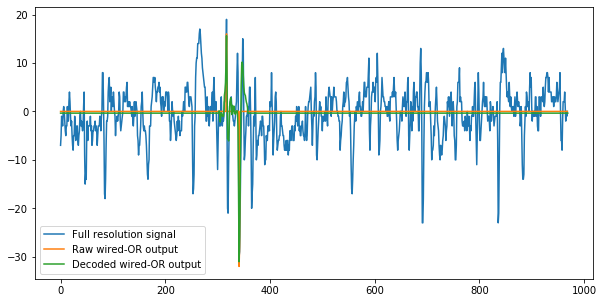

In [50]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

electrode = 5

raw_output_in = raw_output
raw_output_in = raw_output_in.to(device=device, dtype=dtype)
decoded_output = three_layer_decode(raw_output_in, params).to(device = 'cpu').detach().numpy()


ax.plot(full_resolution_signal[electrode, window // 2: - window //2], label = 'Full resolution signal')
ax.plot(raw_output[electrode,  window // 2: - window //2], label = 'Raw wired-OR output')
ax.plot(decoded_output[electrode], label = 'Decoded wired-OR output')

plt.legend()
plt.show()